In [1]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
seed = 42

In [3]:
coin = 'KRW-SEI'

In [4]:
df = pd.read_csv(f'../data/from_pyupbit/{coin}.csv')

In [5]:
df

,timestamp,open,high,low,close,volume,value
0,2023-08-16 10:05:00,254.0,285.0,254.0,285.0,3.759116e+07,9.940495e+09
1,2023-08-16 10:06:00,284.0,318.0,282.0,294.0,2.711361e+07,8.230124e+09
2,2023-08-16 10:07:00,294.0,316.0,293.0,315.0,1.464424e+07,4.452651e+09
3,2023-08-16 10:08:00,316.0,324.0,314.0,324.0,1.805538e+07,5.779843e+09
4,2023-08-16 10:09:00,322.0,338.0,322.0,327.0,1.564268e+07,5.164133e+09
...,...,...,...,...,...,...,...
581650,2024-10-12 22:30:00,643.3,645.0,643.0,644.4,2.887644e+05,1.860721e+08
581651,2024-10-12 22:31:00,644.1,646.0,641.7,644.8,1.747488e+05,1.125094e+08
581652,2024-10-12 22:32:00,644.9,646.0,644.0,644.0,1.870079e+05,1.206430e+08
581653,2024-10-12 22:33:00,644.3,646.2,644.1,645.7,3.088597e+05,1.993958e+08


In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [7]:
df

,open,high,low,close,volume,value
timestamp,,,,,,
2023-08-16 10:05:00,254.0,285.0,254.0,285.0,3.759116e+07,9.940495e+09
2023-08-16 10:06:00,284.0,318.0,282.0,294.0,2.711361e+07,8.230124e+09
2023-08-16 10:07:00,294.0,316.0,293.0,315.0,1.464424e+07,4.452651e+09
2023-08-16 10:08:00,316.0,324.0,314.0,324.0,1.805538e+07,5.779843e+09
2023-08-16 10:09:00,322.0,338.0,322.0,327.0,1.564268e+07,5.164133e+09
...,...,...,...,...,...,...
2024-10-12 22:30:00,643.3,645.0,643.0,644.4,2.887644e+05,1.860721e+08
2024-10-12 22:31:00,644.1,646.0,641.7,644.8,1.747488e+05,1.125094e+08
2024-10-12 22:32:00,644.9,646.0,644.0,644.0,1.870079e+05,1.206430e+08


In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['close'].values.reshape(-1, 1))
joblib.dump(scaler, f'models/{coin}_scaler.pkl')

['models/KRW-SEI_scaler.pkl']

In [9]:
timestep = 1

In [10]:
X = []
y = []
for i in range(len(scaled_data) - timestep - 1):
    X.append(scaled_data[i:(i + timestep), 0])
    y.append(scaled_data[i + timestep, 0])

In [11]:
X, y = np.array(X), np.array(y)

In [12]:
train_size = int(len(X) * .8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
train_dates = df.index[:train_size]
test_dates = df.index[train_size:]

In [14]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timestep, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [16]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
model.fit(X_train, y_train, batch_size=32, epochs=20,
          validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/20
14542/14542 [==============================] - 143s 10ms/step - loss: 2.5771e-04 - val_loss: 3.8901e-06
Epoch 2/20
14542/14542 [==============================] - 170s 12ms/step - loss: 3.2794e-06 - val_loss: 5.1581e-06
Epoch 3/20
14542/14542 [==============================] - 162s 11ms/step - loss: 3.1483e-06 - val_loss: 4.0436e-07
Epoch 4/20
14542/14542 [==============================] - 162s 11ms/step - loss: 3.0089e-06 - val_loss: 1.0690e-06
Epoch 5/20
14542/14542 [==============================] - 157s 11ms/step - loss: 2.8126e-06 - val_loss: 1.4703e-06
Epoch 6/20
14542/14542 [==============================] - 162s 11ms/step - loss: 2.7217e-06 - val_loss: 2.1158e-06
Epoch 7/20
14542/14542 [==============================] - 166s 11ms/step - loss: 2.6065e-06 - val_loss: 5.2118e-07
Epoch 8/20
14542/14542 [==============================] - 164s 11ms/step - loss: 2.5078e-06 - val_loss: 1.3128e-06
Epoch 9/20
14542/14542 [==============================] - 160s 11ms/step - loss:

In [19]:
model.save(f'models/lstm_{coin}.h5')

In [20]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3636/3636 [==============================] - 11s 3ms/step


In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [22]:
test_predict

array([[550.4137 ],
       [550.4137 ],
       [550.71423],
       ...,
       [645.2841 ],
       [645.68494],
       [644.88336]], dtype=float32)

In [23]:
y_test

array([[549.7, 550. , 550. , ..., 644.8, 644. , 645.7]])

In [24]:
train_score = np.sqrt(mean_squared_error(y_train[0], train_predict[:, 0]))
test_score = np.sqrt(mean_squared_error(y_test[0], test_predict[:, 0]))
print(f'Train RMSE: {train_score:.2f}')
print(f'Test RMSE: {test_score:.2f}')

Train RMSE: 2.23
Test RMSE: 1.06


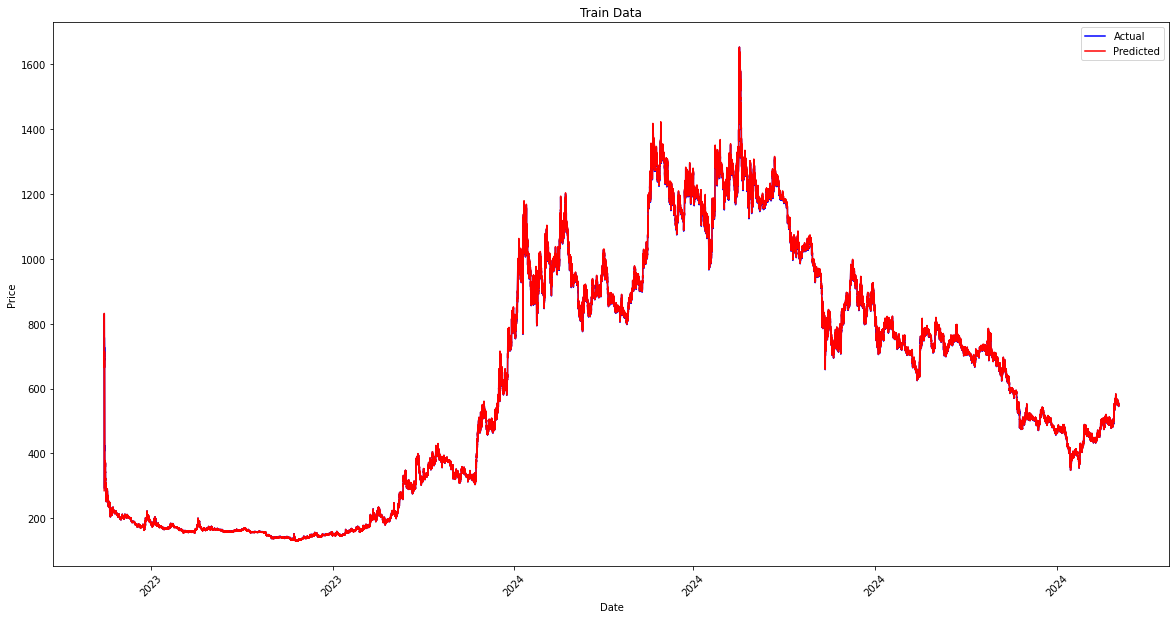

In [25]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 1, 1)
plt.plot(train_dates, y_train[0], label='Actual', color = 'Blue')
plt.plot(train_dates, train_predict, label='Predicted', color = 'Red')
plt.title('Train Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

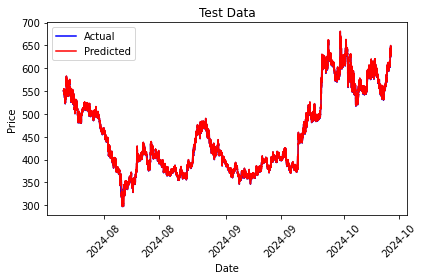

In [26]:
plt.subplot(1, 1, 1)
plt.plot(test_dates[:-2], y_test[0], label='Actual', color = 'Blue')
plt.plot(test_dates[:-2], test_predict, label='Predicted', color = 'Red')
plt.title('Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))

plt.tight_layout()
plt.show()

In [27]:
last_1_day = scaled_data[-timestep:]
X_predict = last_1_day.reshape(1, timestep, 1)
print(last_1_day)

[[0.33929041]]


In [28]:
pred = model.predict(X_predict)
pred = scaler.inverse_transform(pred)
print(pred)

1/1 [==============================] - 0s 14ms/step
[[647.2882]]


In [29]:
preds = []
for i in range(30):
    pred = model.predict(X_predict)
    preds.append(scaler.inverse_transform(pred)[0][0])
    pred = pred.reshape(1, 1, 1)
    X_predict = np.append(X_predict[:, 1:, :], pred, axis=1).reshape(1, timestep, 1)

1/1 [==============================] - 2s 2s/step


In [30]:
preds

[647.2882,
 648.17816,
 649.0699,
 649.96356,
 650.8591,
 651.75635,
 652.65546,
 653.55646,
 654.45935,
 655.36414,
 656.27075,
 657.1793,
 658.0897,
 659.0021,
 659.9164,
 660.8325,
 661.7507,
 662.6707,
 663.5928,
 664.51685,
 665.4428,
 666.3708,
 667.3007,
 668.23267,
 669.1667,
 670.1027,
 671.0408,
 671.9809,
 672.923,
 673.8672]